# The dynamic bandit task

This notebook describes a 2-armed bandit task [[1](https://en.wikipedia.org/wiki/Multi-armed_bandit)] in which counterfactual rewards (i.e. rewards that would have been earned if the unchosen action had been chosen) remain available on forthcoming trials until that action is chosen.

On each trial, a reward becomes available for action $i$ (i.e. the action becomes "baited") with probability $p_i$.
If a baited action is chosen a reward is earned and consumed, and if it is not chosen it remains baited until chosen.
Therefore, the probability that choosing action $i$ is gonna yield a reward ($P_i(R)$) depends on $k$, the number of trials elapsed since action $i$ was last chosen:

\begin{equation}
P_i(R ; k) = 1 - (1 - p_i)^k
\end{equation}

Baiting probability $p_i$ was always different for left and right actions, with typical values $0.05$ and $0.4$.
These values remained fixed for a block of trials (typically ~100 trials), at the end of which they would reverse.

Rats were trained to perform the task, and their behavior was fit with two classes of models.
**Action value models** learn a scalar representation of the reward expected to be earned from chosing each of the two actions, and uses experienced outcomes to update these estimates according to a delta learning rule.
This notebook focuses on this model.
**Ideal observer models** share the mathematical structure of the generative rules used by the task, but must learn the parameters.

The models were then used to infer a decision variable underlying choice behavior, enabling an investigation of decision confidence in a value-guided task.

## Importing libraries and data

The module `lauglim` is used to read and pre-process behavioral data files.
The code block below checks if it is installed, and attempts installing if it is missing.
You can also install it manually from [github](https://github.com/tsgouvea/tasksuite_analysis.git) if necessary.

In [1]:
import importlib, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
if importlib.util.find_spec("tasks") is None:
    import subprocess, sys
    subprocess.check_output([sys.executable, '-m', 'pip', "install", 'git+https://github.com/tsgouvea/tasksuite_analysis.git'])
from tasks import lauglim, tidy_trials

Now, let's load the data.

The function `tidy_trials` uses `lauglim.parseSess()` to read single session data from Bpod files and organize it into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) where rows are trials, and columns are trial features.
The variable `df_tidy_trials` is a concatenation of such single trial dataframes.
The first five trials of an example session are shown below.

In [2]:
df_tidy_trials = tidy_trials(fun = lauglim,
                             datadir = os.path.join(os.getcwd(),'resources','datasets','matching_fix'),
                             forcerun = False) # call to function tidy_trials imported from package tasks
df_tidy_trials = df_tidy_trials.loc[(df_tidy_trials.isChoiceLeft | df_tidy_trials.isChoiceRight),:] # removing trials where no choice was registered
eg_sess = df_tidy_trials.loc[df_tidy_trials.sess == 'TG021_Matching_Aug23_2018_Session1.mat',:].copy() # filtering dataframe for example session
display(eg_sess.loc[:,['isChoiceLeft', 'isChoiceRight', 'isRewarded','isBrokeFix','isEarlyWithdr',
                       'isLeftHi','isBaitLeft','isBaitRight','isChoiceBaited',
                       'waitingTime','reactionTime','movementTime','pLo','pHi']].head(5)) # displaying top rows and selected columns of example session

Reading dataframe from file.


,isChoiceLeft,isChoiceRight,isRewarded,isBrokeFix,isEarlyWithdr,isLeftHi,isBaitLeft,isBaitRight,isChoiceBaited,waitingTime,reactionTime,movementTime,pLo,pHi
iTrial,,,,,,,,,,,,,,
0,True,False,True,False,False,True,True,True,True,1.0001,0.6546,0.2798,5.0,40.0
1,False,True,True,False,False,True,True,True,True,1.0001,0.0492,0.2701,5.0,40.0
2,False,True,False,False,False,True,True,False,False,2.0812,0.0538,0.2579,5.0,40.0
3,True,False,True,False,False,True,True,False,True,1.0001,0.3230,0.3012,5.0,40.0
4,False,True,False,False,False,True,False,False,False,2.0602,0.4952,0.2418,5.0,40.0


## Choice tracks income ratio

Each session is comprised of several blocks of about a hundred trials each.
Within each block, one of the two available actions (left and right) is richer than the other on average.
The *matching law* [[2](https://onlinelibrary.wiley.com/doi/abs/10.1901/jeab.1961.4-267),[3](https://en.wikipedia.org/wiki/Matching_law)] predicts that, in situations like this, the fraction of choices allocated to each available action should track the corresponding rate of reinforcement.

The figure below shows a rolling average of the fraction of trials when the left action was chosen (**choice ratio**), as well as block averages.
Similarly, block averages of the fraction of rewards earned following a left choice over total rewards earned (**income ratio**) are also shown.
Data is from the example session displayed above.

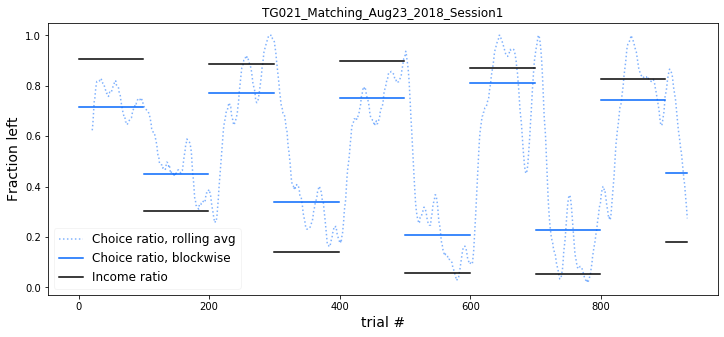

In [3]:
plt.figure(figsize=(12,5))
plt.plot(eg_sess.isChoiceLeft.rolling(20, win_type='gaussian').mean(std=5),':',color='xkcd:bright blue',alpha=.5,label='Choice ratio, rolling avg')
if 'labelRwd' in locals(): del labelRwd
if 'labelCho' in locals(): del labelCho
for iBlock in eg_sess.iBlock.drop_duplicates().values:
    ndx = eg_sess.iBlock==iBlock
    blockEdges = np.percentile(eg_sess.loc[ndx].index,[0,100])
    labelCho = '' if 'labelCho' in locals() else 'Choice ratio, blockwise'
    plt.plot(blockEdges,
             np.ones(2)*eg_sess.loc[ndx,'isChoiceLeft'].mean(),
            color='xkcd:bright blue',label=labelCho)
    labelRwd = '' if 'labelRwd' in locals() else 'Income ratio'
    plt.plot(blockEdges,
             np.ones(2)*(eg_sess.loc[ndx,'isRewarded'] & eg_sess.loc[ndx,'isChoiceLeft']).sum()/eg_sess.loc[ndx,'isRewarded'].sum(),
             color='xkcd:black',label=labelRwd)

plt.xlabel('trial #',fontsize=14)
plt.ylabel('Fraction left',fontsize=14)
plt.title(eg_sess.sess.drop_duplicates().values.item().split('.')[0])
plt.legend(fontsize=12,framealpha=.2)

## UNCOMENT TO PLOT INDIVIDUAL CHOICES
# plt.plot(eg_sess.isChoiceLeft.loc[eg_sess.isRewarded==0],'o',color='xkcd:red',alpha=.3)
# plt.plot(eg_sess.isChoiceLeft.loc[eg_sess.isRewarded],'o',color='xkcd:green',alpha=.3)


**Figure 1** - 
Choice ratio (fraction of choices allocated to the left action) and income ratio (fraction of rewards earned following a left action) for an example session.
Dotted line is rolling average.
Solid lines are within-block averages.
$p_{\text{left}} = 0.40$ and $p_{\text{right}} = 0.05$ for the first block of trials, and values were reversed at each block transition.

## Modeling single trial decisions

Figure 1 shows a bird eye view of how choices are influenced by experienced rewards: within each block of trials, a higher proportion of choices is allocated to the action that yields most of the rewards.
But how well can any single choice be predicted?
One approach found in the literature is to predict choices from trial history using a logistic regression [[2](https://onlinelibrary.wiley.com/doi/abs/10.1901/jeab.2005.110-04)].
We replicate that below.

### Trial History model

We start by defining the function `lrdesign`.
It takes a *tidy_trials* dataframe as input, and returns the [design matrix](https://en.wikipedia.org/wiki/Design_matrix) *X* and the response variable array *y*.
Predictors included in the design matrix are choices and rewards observed on preceding trials, and the response variable is the observed upcoming choice.
The optional argument *nTrialsBack* is an integer defining the length of trial history to be considered.

In [4]:
def lrdesign(df,nTrialsBack=10):
    # df is a tidy_trials dataframe - e.g. output of lauglim.parseSess()
    # nTrialsBack is an int defining length of trial history to be considered

    df = df.loc[(df.isChoiceLeft|df.isChoiceRight),:] # discard trials where no choice was recorded
    
    y = df.isChoiceLeft.astype(int); y[y==0] = -1 # outcome variable in {-1,1}
    tempR = np.multiply(y,df.isRewarded)
    X = pd.DataFrame(columns=['C-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)]+['R-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)],
                     index=df.index,data=0,dtype=int)
    for i in range(nTrialsBack):
        X.iloc[i+1:,X.columns.get_loc('C-{0:0>2}'.format(i+1))] = y.values[:-i-1]
        X.iloc[i+1:,X.columns.get_loc('R-{0:0>2}'.format(i+1))] = tempR.values[:-i-1]
        
    return X, y

Next, we run the logistic regression on the example session with scikit-learn.
Logistic regression models the log odds ratio of a left choice as a linear function of the predictors:
\begin{equation}
\log \frac{P(\text{left choice})}{P(\text{right choice})} = \beta_0 + \mathbf{x} \cdot \mathbf{\beta_1}
\end{equation}

In [5]:
from sklearn import linear_model

X, y = lrdesign(eg_sess,nTrialsBack=20)
mdl = linear_model.LogisticRegression(solver='lbfgs').fit(X=X,y=y)

Trials are binned based on the estimated log odds ratio of a left choice (decision variable).
Regression coefficients and results are displayed in table 1 and figure 2.

In [6]:
eg_sess['dv'] = mdl.intercept_ + X @ mdl.coef_.T # decision variable 
eg_sess['dv_binned'], bins = pd.qcut(eg_sess['dv'],q=8,precision=1,retbins=True)
pivot = eg_sess.pivot_table(values='isChoiceLeft',index='dv_binned')
display(pivot)

,isChoiceLeft
dv_binned,
"(-4.8, -2.2]",0.055046
"(-2.2, -1.1]",0.092593
"(-1.1, -0.2]",0.351852
"(-0.2, 0.4]",0.574074
"(0.4, 1.0]",0.712963
"(1.0, 1.7]",0.768519
"(1.7, 2.6]",0.879630
"(2.6, 5.4]",0.972222


**Table 1** - Fraction of choice left trials after binning on decision variable. Data from example session in figure 1.

Text(0.5, 0.98, 'TG021_Matching_Aug23_2018_Session1')

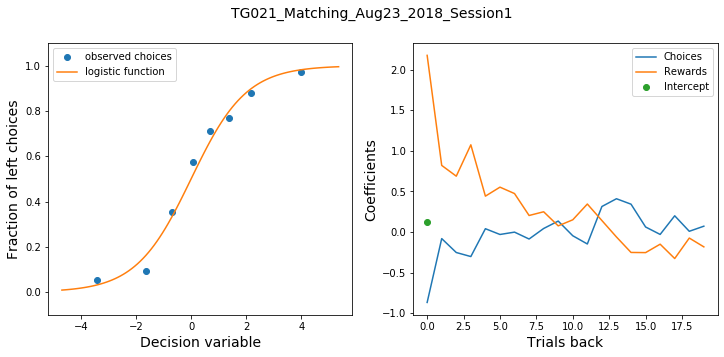

In [7]:
hf, ha = plt.subplots(1,2,figsize=(12,5))


ha[0].plot(pd.Series(bins).rolling(2).mean().dropna(), pivot.values.ravel(),'o',label='observed choices')
xdata = np.linspace(eg_sess['dv'].min(),eg_sess['dv'].max(),100)
ydata = 1./(1+np.exp(-xdata))
ha[0].plot(xdata,ydata,label='logistic function')
ha[0].set_ylim((-.1,1.1))
ha[0].set_xlabel('Decision variable',fontsize=14)
ha[0].set_ylabel('Fraction of left choices',fontsize=14)
ha[0].legend()

ha[1].plot(mdl.coef_[0][[col.startswith('C') for col in X.columns]],label='Choices')
ha[1].plot(mdl.coef_[0][[col.startswith('R') for col in X.columns]],label='Rewards')
ha[1].plot(0,mdl.intercept_,'o',label='Intercept')
ha[1].set_xlabel('Trials back',fontsize=14)
ha[1].set_ylabel('Coefficients',fontsize=14)
ha[1].legend()

hf.suptitle(eg_sess.sess.drop_duplicates().values.item().split('.')[0],fontsize=14)

**Figure 2** - 
[**Left**] Fraction of left choices as function of decision variable (i.e. log odds ratio estimated by logistic regression).
[**Right**] Regression coefficients of logistic regression, indicating by how much the log odds ratio of a choice being repeated on the upcoming trial is expected to change given trial history.
Data from same example session as in figure 1.

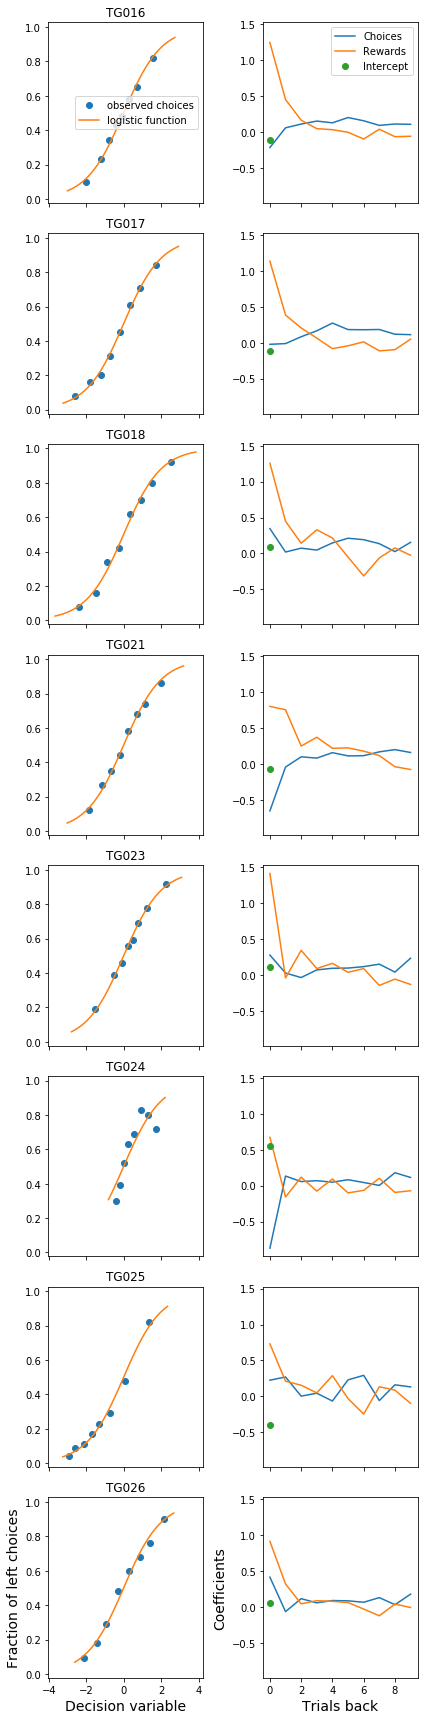

In [116]:
X = dict()
y = dict()
pivot = dict()

nTrialsBack=10

listSubj = df_tidy_trials['subj'].drop_duplicates()
nSubj = len(listSubj)
hf, ha = plt.subplots(nSubj,2,figsize=(6,nSubj*3),sharex='col',sharey='col')
for isubj, subj in enumerate(listSubj):
    df_subj = df_tidy_trials.loc[df_tidy_trials['subj'] == subj,:].copy()
    listSess = df_subj['sess'].drop_duplicates()
    for isess, sess in enumerate(listSess):
        tempX, tempy = lrdesign(df_subj.loc[df_subj['sess'] == sess,:],nTrialsBack=nTrialsBack)
        X[subj] = pd.concat((X[subj],tempX)) if subj in X.keys() else tempX
        y[subj] = pd.concat((y[subj],tempy)) if subj in y.keys() else tempy
    mdl[subj] = linear_model.LogisticRegression(solver='lbfgs').fit(X=X[subj],y=y[subj])
    df_subj['dv'] = mdl[subj].intercept_ + X[subj] @ mdl[subj].coef_.T
    df_subj['dv_binned'] = pd.qcut(df_subj['dv'],q=8,precision=1,retbins=False)
    pivot[subj] = df_subj.pivot_table(values=['dv','isChoiceLeft'],index='dv_binned').round(2)
    
    ha[isubj,0].plot(pivot[subj]['dv'], pivot[subj]['isChoiceLeft'],'o',label='observed choices')
    xdata = np.linspace(df_subj['dv'].min(),df_subj['dv'].max(),100)
    ydata = 1./(1+np.exp(-xdata))
    ha[isubj,0].plot(xdata,ydata,label='logistic function')
    # ha[isubj,0].set_ylim((-.1,1.1))
    ha[isubj,0].set_title(subj)
       
    ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('C') for col in X[subj].columns]],label='Choices')
    ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('R') for col in X[subj].columns]],label='Rewards')
    ha[isubj,1].plot(0,mdl[subj].intercept_,'o',label='Intercept')
    if isubj == 0:
        ha[isubj,0].legend()
        ha[isubj,1].legend()
    if isubj == nSubj-1:
        ha[isubj,0].set_xlabel('Decision variable',fontsize=14),
        ha[isubj,0].set_ylabel('Fraction of left choices',fontsize=14)
        ha[isubj,1].set_xlabel('Trials back',fontsize=14),
        ha[isubj,1].set_ylabel('Coefficients',fontsize=14)


plt.tight_layout()

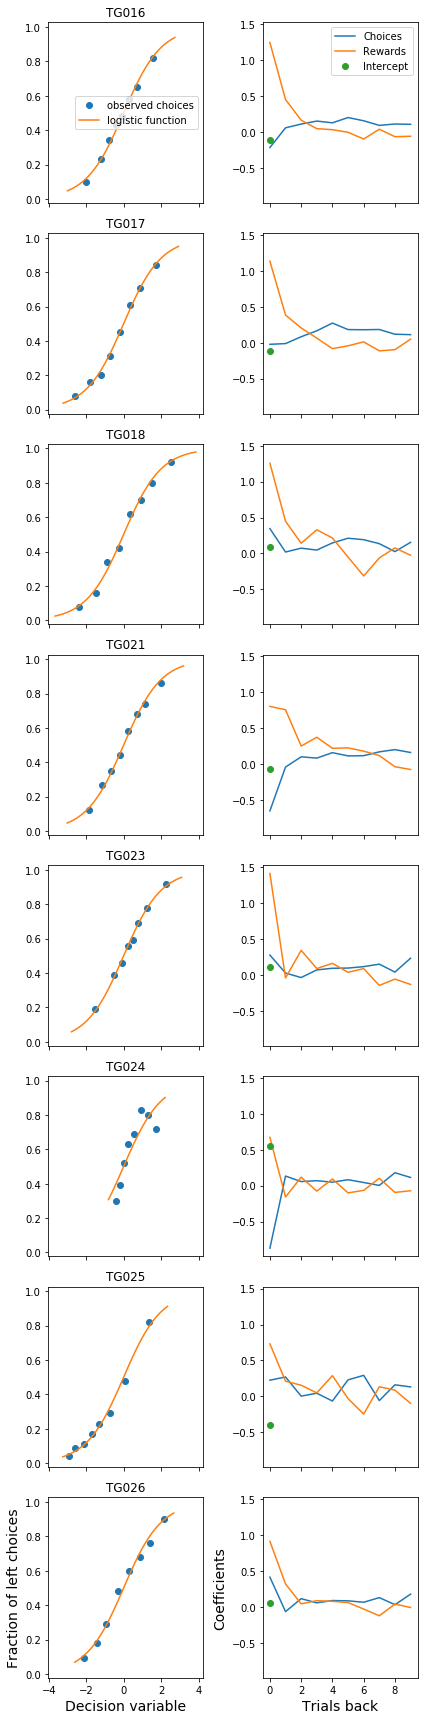

In [116]:
X = dict()
y = dict()
pivot = dict()

nTrialsBack=10

listSubj = df_tidy_trials['subj'].drop_duplicates()
nSubj = len(listSubj)
hf, ha = plt.subplots(nSubj,2,figsize=(6,nSubj*3),sharex='col',sharey='col')
for isubj, subj in enumerate(listSubj):
    df_subj = df_tidy_trials.loc[df_tidy_trials['subj'] == subj,:].copy()
    listSess = df_subj['sess'].drop_duplicates()
    for isess, sess in enumerate(listSess):
        tempX, tempy = lrdesign(df_subj.loc[df_subj['sess'] == sess,:],nTrialsBack=nTrialsBack)
        
        X[subj] = pd.concat((X[subj],tempX)) if subj in X.keys() else tempX
        y[subj] = pd.concat((y[subj],tempy)) if subj in y.keys() else tempy
    mdl[subj] = linear_model.LogisticRegression(solver='lbfgs').fit(X=X[subj],y=y[subj])
    df_subj['dv'] = mdl[subj].intercept_ + X[subj] @ mdl[subj].coef_.T
    df_subj['dv_binned'] = pd.qcut(df_subj['dv'],q=8,precision=1,retbins=False)
    pivot[subj] = df_subj.pivot_table(values=['dv','isChoiceLeft'],index='dv_binned').round(2)
    
    ha[isubj,0].plot(pivot[subj]['dv'], pivot[subj]['isChoiceLeft'],'o',label='observed choices')
    xdata = np.linspace(df_subj['dv'].min(),df_subj['dv'].max(),100)
    ydata = 1./(1+np.exp(-xdata))
    ha[isubj,0].plot(xdata,ydata,label='logistic function')
    # ha[isubj,0].set_ylim((-.1,1.1))
    ha[isubj,0].set_title(subj)
       
    ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('C') for col in X[subj].columns]],label='Choices')
    ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('R') for col in X[subj].columns]],label='Rewards')
    ha[isubj,1].plot(0,mdl[subj].intercept_,'o',label='Intercept')
    if isubj == 0:
        ha[isubj,0].legend()
        ha[isubj,1].legend()
    if isubj == nSubj-1:
        ha[isubj,0].set_xlabel('Decision variable',fontsize=14),
        ha[isubj,0].set_ylabel('Fraction of left choices',fontsize=14)
        ha[isubj,1].set_xlabel('Trials back',fontsize=14),
        ha[isubj,1].set_ylabel('Coefficients',fontsize=14)


plt.tight_layout()

## Task description

*Variation on a theme*

The task structure is similar to that of typical rodent perceptual decision tasks (e.g. [Uchida and Mainen, 2003](https://www.nature.com/articles/nn1142)).
In fact, the present implementation uses code adapted from the perceptual decision task used in the KepecsLab (see [lab's github page](https://github.com/KepecsLab/BpodProtocols_Olf2AFC)).

In summary, in a behavioral cage equipped with three nose ports, an animal initiates a trial by responding at the illuminated center port with a nose-poke.
If the animal successfully holds his snout at the center port for the required duration (**stimulus delay**, typically a random duration between 200-500 ms, distributed uniformly or exponentially), a go-tone will be played, and the two lateral ports will become illuminated prompting the animal to make a choice.
The response at one of the lateral choice ports must also be held for a required duration (**feedback delay**, typically fixed or random exponential), after which a feedback stimulus is delivered according to task contingency (e.g. water reward, a sound tone, no stimulus).

Choices can be either rewarded or unrewarded. Whether or not an unrewarded choice is cued with a white noise tone is controlled by the **CatchUnrwd** tickbox on the protocol Bpod GUI (unchecked means no cue).

Choices are rewarded when the chosen port is on a baited state.
Ports switch from unbaited to baited state with probabilities controlled by **pLo** and **pHi**.
On every block of trials, pLo refers to one of the ports, and pHi to the other.
Whether or not pHi refers to the left port on a given block of trials is registered on the bpod custom data field **leftHi**.

Block length is controlled by **blockMin** and **blockMax**. Actual block lenght is a random variable, distributed exponentially with mean parameter equal to the geometrical mean of blockMin and blockMax, and truncated at these values.